# New York University
## Applied Data Science 2016 Final Project
----
## Measuring household income under Redatam in CensusData
----
### *1. Model by Individual*
----
**Project Description:** Lorem ipsum

**Members:**
- Felipe Gonzales
- Ilan Reinstein
- Fernando Melchor
- Nicolas Metallo

**Sources:**
- http://dlab-geo.github.io/geocoding-geopy/slides/index.html#2
- https://gist.github.com/rgdonohue/c4beedd3ca47d29aef01
- http://darribas.org/gds_scipy16/ipynb_md/07_spatial_clustering.html
- https://glenbambrick.com/2016/01/09/csv-to-shapefile-with-pyshp/
- http://statsmodels.sourceforge.net/devel/examples/generated/example_wls.html

# LIBRARIES

In [24]:
# helper functions
import getEPH
import categorize
import schoolYears
import make_dummy
import functionsForModels
# libraries
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)
np.random.seed(1024)
%matplotlib inline

# DATA HANDLING

In [25]:
# get data using 'getEPHdbf' function

getEPH.getEPHdbf('t310')

('Downloading', 't310')
file in place, creating CSV file
csv file cleanDataHousehold t310 .csv successfully created in folder data/
csv file cleanData t310 .csv successfully created in folder data/


In [26]:
data1 = pd.read_csv('data/cleanDatat310.csv')

In [27]:
data2 = categorize.categorize(data1)
data3 = schoolYears.schoolYears(data2)
data = make_dummy.make_dummy(data3)

In [28]:
dataModel = functionsForModels.prepareDataForModel(data)

In [29]:
dataModel.head()

,PONDERA,P47T,P21,primary,secondary,university,male_14to24,male_25to34,female_14to24,female_25to34,female_35more,female,age,education,education2,age2,lnIncome,lnIncomeT
2,1674,3000,3000,7.0,0.0,0.0,0,0,0,0,0,0,42,7.0,49.0,1764,8.006368,8.006368
3,1674,2800,2800,7.0,5.0,5.0,0,0,0,0,1,1,44,17.0,289.0,1936,7.937375,7.937375
7,1320,6000,5000,7.0,5.0,5.0,0,0,0,0,0,0,38,17.0,289.0,1444,8.517193,8.699515
8,1320,4000,4000,7.0,5.0,5.0,0,0,0,1,0,1,28,17.0,289.0,784,8.294050,8.294050
9,1281,3800,3800,7.0,5.0,5.0,0,0,0,0,0,0,63,17.0,289.0,3969,8.242756,8.242756


# DATA EXPLORATION

## Plot for: Education ~ Age

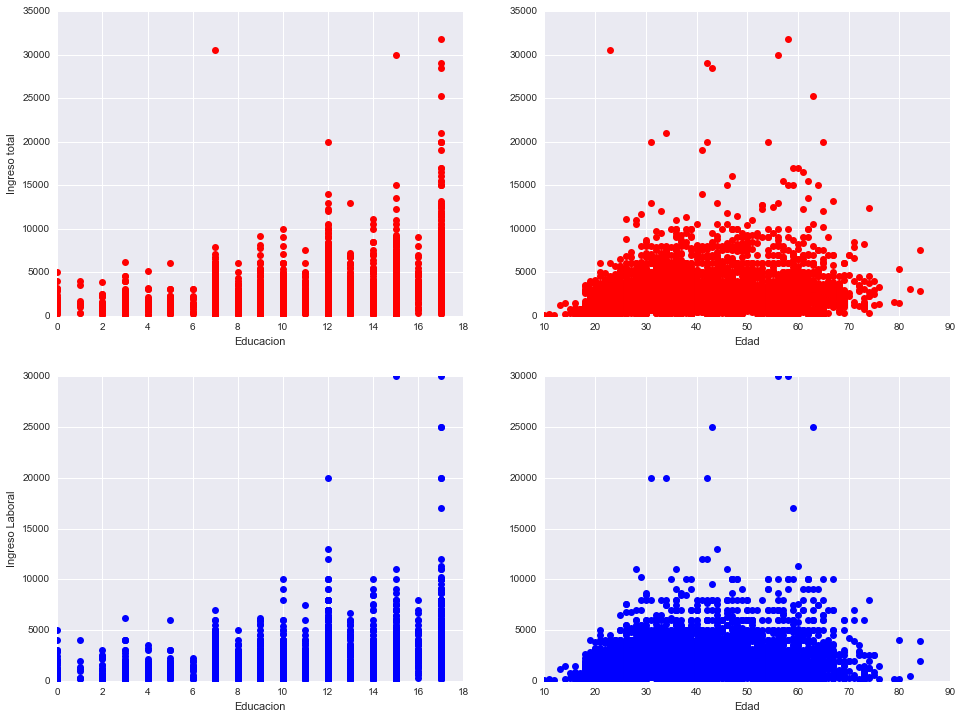

In [30]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.plot(dataModel.education,dataModel.P47T,'ro')
ax1.set_ylabel('Ingreso total')
ax1.set_xlabel('Educacion')
ax2.plot(dataModel.age,dataModel.P47T,'ro')
ax2.set_xlabel('Edad')
ax3.plot(dataModel.education,dataModel.P21,'bo')
ax3.set_ylabel('Ingreso Laboral')
ax3.set_xlabel('Educacion')
ax4.plot(dataModel.age,dataModel.P21,'bo')
ax4.set_xlabel('Edad')

### Reference:
- **P21**: Refers to individual income by main activity (occupation)
- **P47T**: Refers to total individual income (includes capital gains)
- **lnIncomeT**: Refers to ln of P21
- **lnIncome**: Refers to ln of P47T

## Plot for: LnIncome

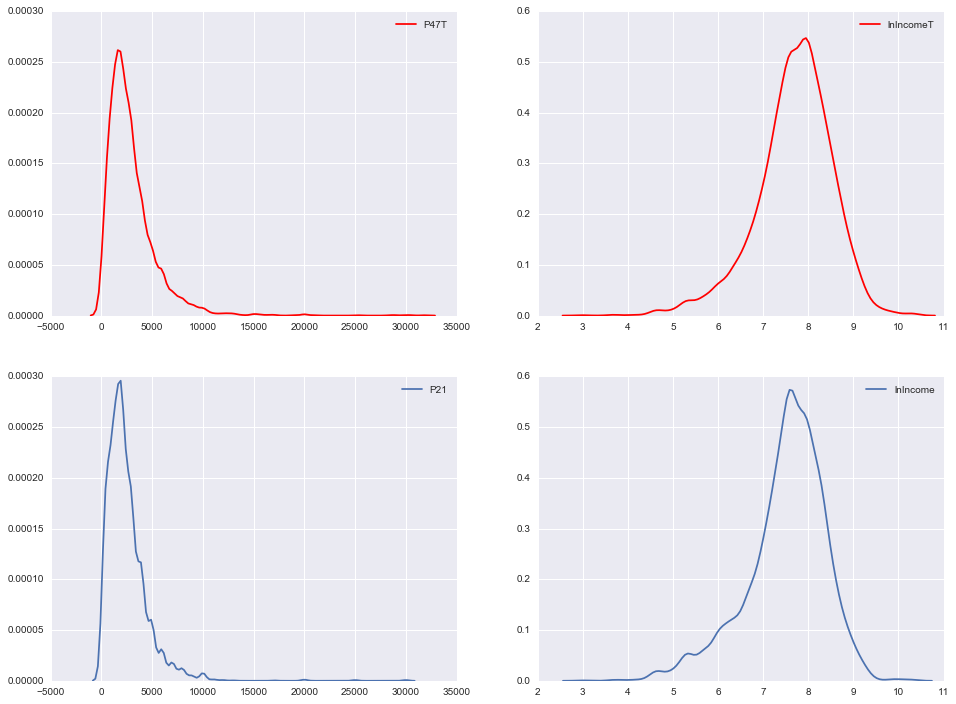

In [31]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

sns.kdeplot(dataModel.P47T,ax=ax1,color = 'red')
sns.kdeplot(dataModel.lnIncomeT,ax=ax2,color = 'red')
sns.kdeplot(dataModel.P21,ax=ax3)
sns.kdeplot(dataModel.lnIncome,ax=ax4)

In [32]:
print 'mean:', dataModel.lnIncome.mean(), 'std:', dataModel.lnIncome.std()

mean: 7.50403461536 std: 0.876203364122


In [33]:
print 'mean:', dataModel.P21.mean(), 'std:', dataModel.P21.std()

mean: 2488.57982262 std: 2063.59290863


{'boxes': [<matplotlib.lines.Line2D at 0x11fe8d1d0>],
 'caps': [<matplotlib.lines.Line2D at 0x11fe9b0d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x11fea63d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11fe9bd50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x11d0d0c90>,
  <matplotlib.lines.Line2D at 0x11fe8da50>]}

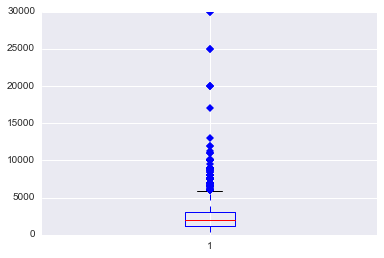

In [34]:
plt.boxplot(list(dataModel.P21), 0, 'gD')

## Plot for: LnIncome ~ Educ and Age

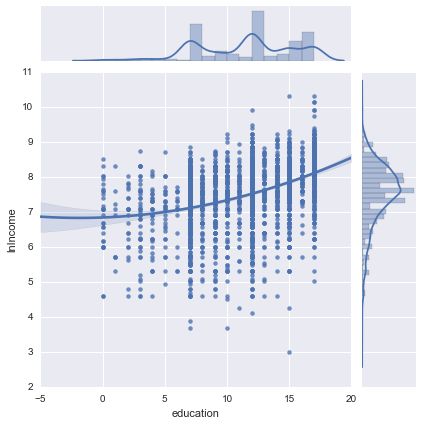

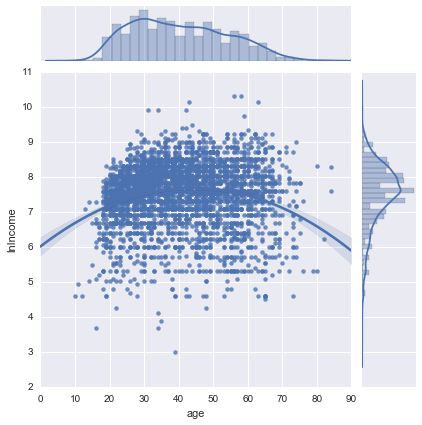

In [35]:
g = sns.JointGrid(x="education", y="lnIncome", data=dataModel)  
g.plot_joint(sns.regplot, order=2)  
g.plot_marginals(sns.distplot)

g2 = sns.JointGrid(x="age", y="lnIncome", data=dataModel)  
g2.plot_joint(sns.regplot, order=2)  
g2.plot_marginals(sns.distplot)

# REGRESSION MODEL (ECLAC)

### Background:

The ECLAC (Economic Comission for Latin America and the Caribbean) estimates income by using a regression model based on the following variables (education, gender and age):
- x1: primary
- x2: secondary
- x3: university
- x4: male_14to24
- x5: male_25to34
- x6: female_14to24
- x7: female_25to34
- x8: female_35more

### MODEL # 1 - ECLAC

In [36]:
dataModel1 = functionsForModels.runModel(dataModel, income = 'P21')

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.256
Model:                            WLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     154.7
Date:                Sun, 11 Dec 2016   Prob (F-statistic):          1.74e-224
Time:                        22:13:00   Log-Likelihood:                -32126.
No. Observations:                3608   AIC:                         6.427e+04
Df Residuals:                    3599   BIC:                         6.433e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       1707.4296    219.005      7.796      0.0

### MODEL # 2 - ECLAC (Using Log of Individual Income)

In [37]:
dataModel2 = functionsForModels.runModel(dataModel, income = 'lnIncome', variables= [
        'primary','secondary','university',
        'male_14to24','male_25to34',
        'female_14to24', 'female_25to34', 'female_35more'])

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.274
Model:                            WLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     169.6
Date:                Sun, 11 Dec 2016   Prob (F-statistic):          1.71e-243
Time:                        22:13:04   Log-Likelihood:                -4124.3
No. Observations:                3608   AIC:                             8267.
Df Residuals:                    3599   BIC:                             8322.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.8690      0.093     73.616      0.0

### MODEL # 3 - ECLAC (Using Total Individual Income)

In [38]:
dataModel3 = functionsForModels.runModel(dataModel, income = 'P47T')

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.253
Model:                            WLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     152.0
Date:                Sun, 11 Dec 2016   Prob (F-statistic):          4.78e-221
Time:                        22:13:08   Log-Likelihood:                -32860.
No. Observations:                3608   AIC:                         6.574e+04
Df Residuals:                    3599   BIC:                         6.579e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       2004.2388    268.448      7.466      0.0

### MODEL # 4 - ECLAC (Using Log of Total Individual Income)

In [39]:
dataModel4 = functionsForModels.runModel(dataModel, income = 'lnIncomeT')

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            WLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     165.6
Date:                Sun, 11 Dec 2016   Prob (F-statistic):          2.03e-238
Time:                        22:13:12   Log-Likelihood:                -3972.8
No. Observations:                3608   AIC:                             7964.
Df Residuals:                    3599   BIC:                             8019.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          7.2029      0.089     80.505      0.0

# REGRESSION MODEL (ALTERNATIVE)

### Background:

We tested an alternative model similar to the ECLAC Regression Model using a second polynomial to account for the non-linear relationship between age, education and income. 

### MODEL # 1 - ALTERNATIVE (Using Log of Total Individual Income)

In [40]:
dataModel5 = functionsForModels.runModel(dataModel, income = 'lnIncomeT', variables=['education','education2',
                                'age','age2','female'])

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.275
Model:                            WLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     272.8
Date:                Sun, 11 Dec 2016   Prob (F-statistic):          5.89e-248
Time:                        22:13:16   Log-Likelihood:                -3959.0
No. Observations:                3608   AIC:                             7930.
Df Residuals:                    3602   BIC:                             7967.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.0980      0.133     45.843      0.0

### MODEL # 1 - ALTERNATIVE (Using Log of Individual Income)

In [41]:
dataModel6 = functionsForModels.runModel(dataModel, income = 'lnIncome', variables=['education','education2',
                                'age','age2','female'])

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.287
Model:                            WLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     289.9
Date:                Sun, 11 Dec 2016   Prob (F-statistic):          2.70e-261
Time:                        22:13:19   Log-Likelihood:                -4091.5
No. Observations:                3608   AIC:                             8195.
Df Residuals:                    3602   BIC:                             8232.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.5938      0.138     40.537      0.0